# Human Activity Recognition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Highlights from Data Description:
* 561 features
* Data is normalized and features are bound within [-1,1]

Therefore it is not necessary to scale the data; however, due to the number of features a method of dimensionality reduction must be implemented.

#### Import data as pandas dataframe, correctly assign feature names and target labels

In [2]:
X_names = pd.read_csv('UCI HAR Dataset/features.txt', sep='\s+', names=['id','feature'])
X_names = X_names['feature'].tolist()

X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', sep='\s+',names=X_names)
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', sep='\s+', names=X_names)


label_map = {row.id: row.label for i, row in pd.read_csv('UCI HAR Dataset/activity_labels.txt', sep = '\s+', 
                                                         names=['id','label']).iterrows()}

y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', names=['activity_id'])
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', names=['activity_id'])

y_train['activity']=y_train.activity_id.map(label_map)
y_test['activity']=y_test.activity_id.map(label_map)


C:\Users\alros\Anaconda2\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
C:\Users\alros\Anaconda2\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


#### Check that each activity is more or less equally represented in both the training and testing sets.

In [3]:
print 'Activity Count Training Data:\n{}\n\nActivity Count Testing Data:\n{}'.format(pd.value_counts(y_train['activity']),
                                                                              pd.value_counts(y_test['activity']))

Activity Count Training Data:
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: activity, dtype: int64

Activity Count Testing Data:
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: activity, dtype: int64


### Dealing with Duplicates
* There are duplicate labels, but this is not an issue since we are not going to be using the label names.
* There are duplicate columns. This is likely due to the data being normalized. These columns will be removed such that the particular measurements being made are not overemphasized by PCA. 

#### Examine and Remove Duplicate Columns

In [4]:
index = []
dup_pairs = []
dup = []
for i in range(X_train.shape[1]):
    for j in range(X_train.shape[1]):
        if np.array_equal(X_train.iloc[:,i].values, X_train.iloc[:,j].values) and i!=j and i not in index and j not in index:
            index.append(i)
            dup_pairs.append((X_train.keys()[i],X_train.keys()[j]))
            dup.append(X_train.keys()[j])
dup_pairs

[('tBodyAccMag-mean()', 'tBodyAccMag-sma()'),
 ('tBodyAccMag-std()', 'tGravityAccMag-std()'),
 ('tBodyAccMag-mad()', 'tGravityAccMag-mad()'),
 ('tBodyAccMag-max()', 'tGravityAccMag-max()'),
 ('tBodyAccMag-min()', 'tGravityAccMag-min()'),
 ('tBodyAccMag-sma()', 'tGravityAccMag-mean()'),
 ('tBodyAccMag-energy()', 'tGravityAccMag-energy()'),
 ('tBodyAccMag-iqr()', 'tGravityAccMag-iqr()'),
 ('tBodyAccMag-entropy()', 'tGravityAccMag-entropy()'),
 ('tBodyAccMag-arCoeff()1', 'tGravityAccMag-arCoeff()1'),
 ('tBodyAccMag-arCoeff()2', 'tGravityAccMag-arCoeff()2'),
 ('tBodyAccMag-arCoeff()3', 'tGravityAccMag-arCoeff()3'),
 ('tBodyAccMag-arCoeff()4', 'tGravityAccMag-arCoeff()4'),
 ('tGravityAccMag-mean()', 'tGravityAccMag-sma()'),
 ('tBodyAccJerkMag-mean()', 'tBodyAccJerkMag-sma()'),
 ('tBodyGyroMag-mean()', 'tBodyGyroMag-sma()'),
 ('tBodyGyroJerkMag-mean()', 'tBodyGyroJerkMag-sma()'),
 ('fBodyAccMag-mean()', 'fBodyAccMag-sma()'),
 ('fBodyBodyAccJerkMag-mean()', 'fBodyBodyAccJerkMag-sma()'),
 ('fB

#### Based on the label names, it does seem likely that the duplicate columns are produced due to normalization performed on the data prior to it being made available to the public

In [5]:
#Remove duplicate columns from training and testing data
X_train = X_train.drop(dup, axis=1)
X_test = X_test.drop(dup, axis=1)

### Dimensionality Reduction with PCA

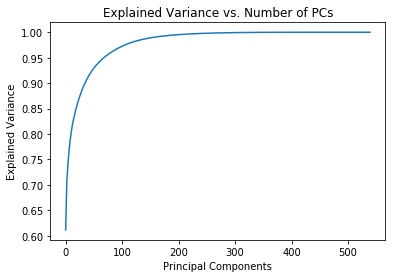

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.title('Explained Variance vs. Number of PCs')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance');

### From the plot it is clear that:
* ~70 components account for 95% of the variance
* 100 components account for ~98% of the variance
* 200 components account for nearly 100% of the variance

### Visualize first 10 Principal Components and Make Performance Predictions

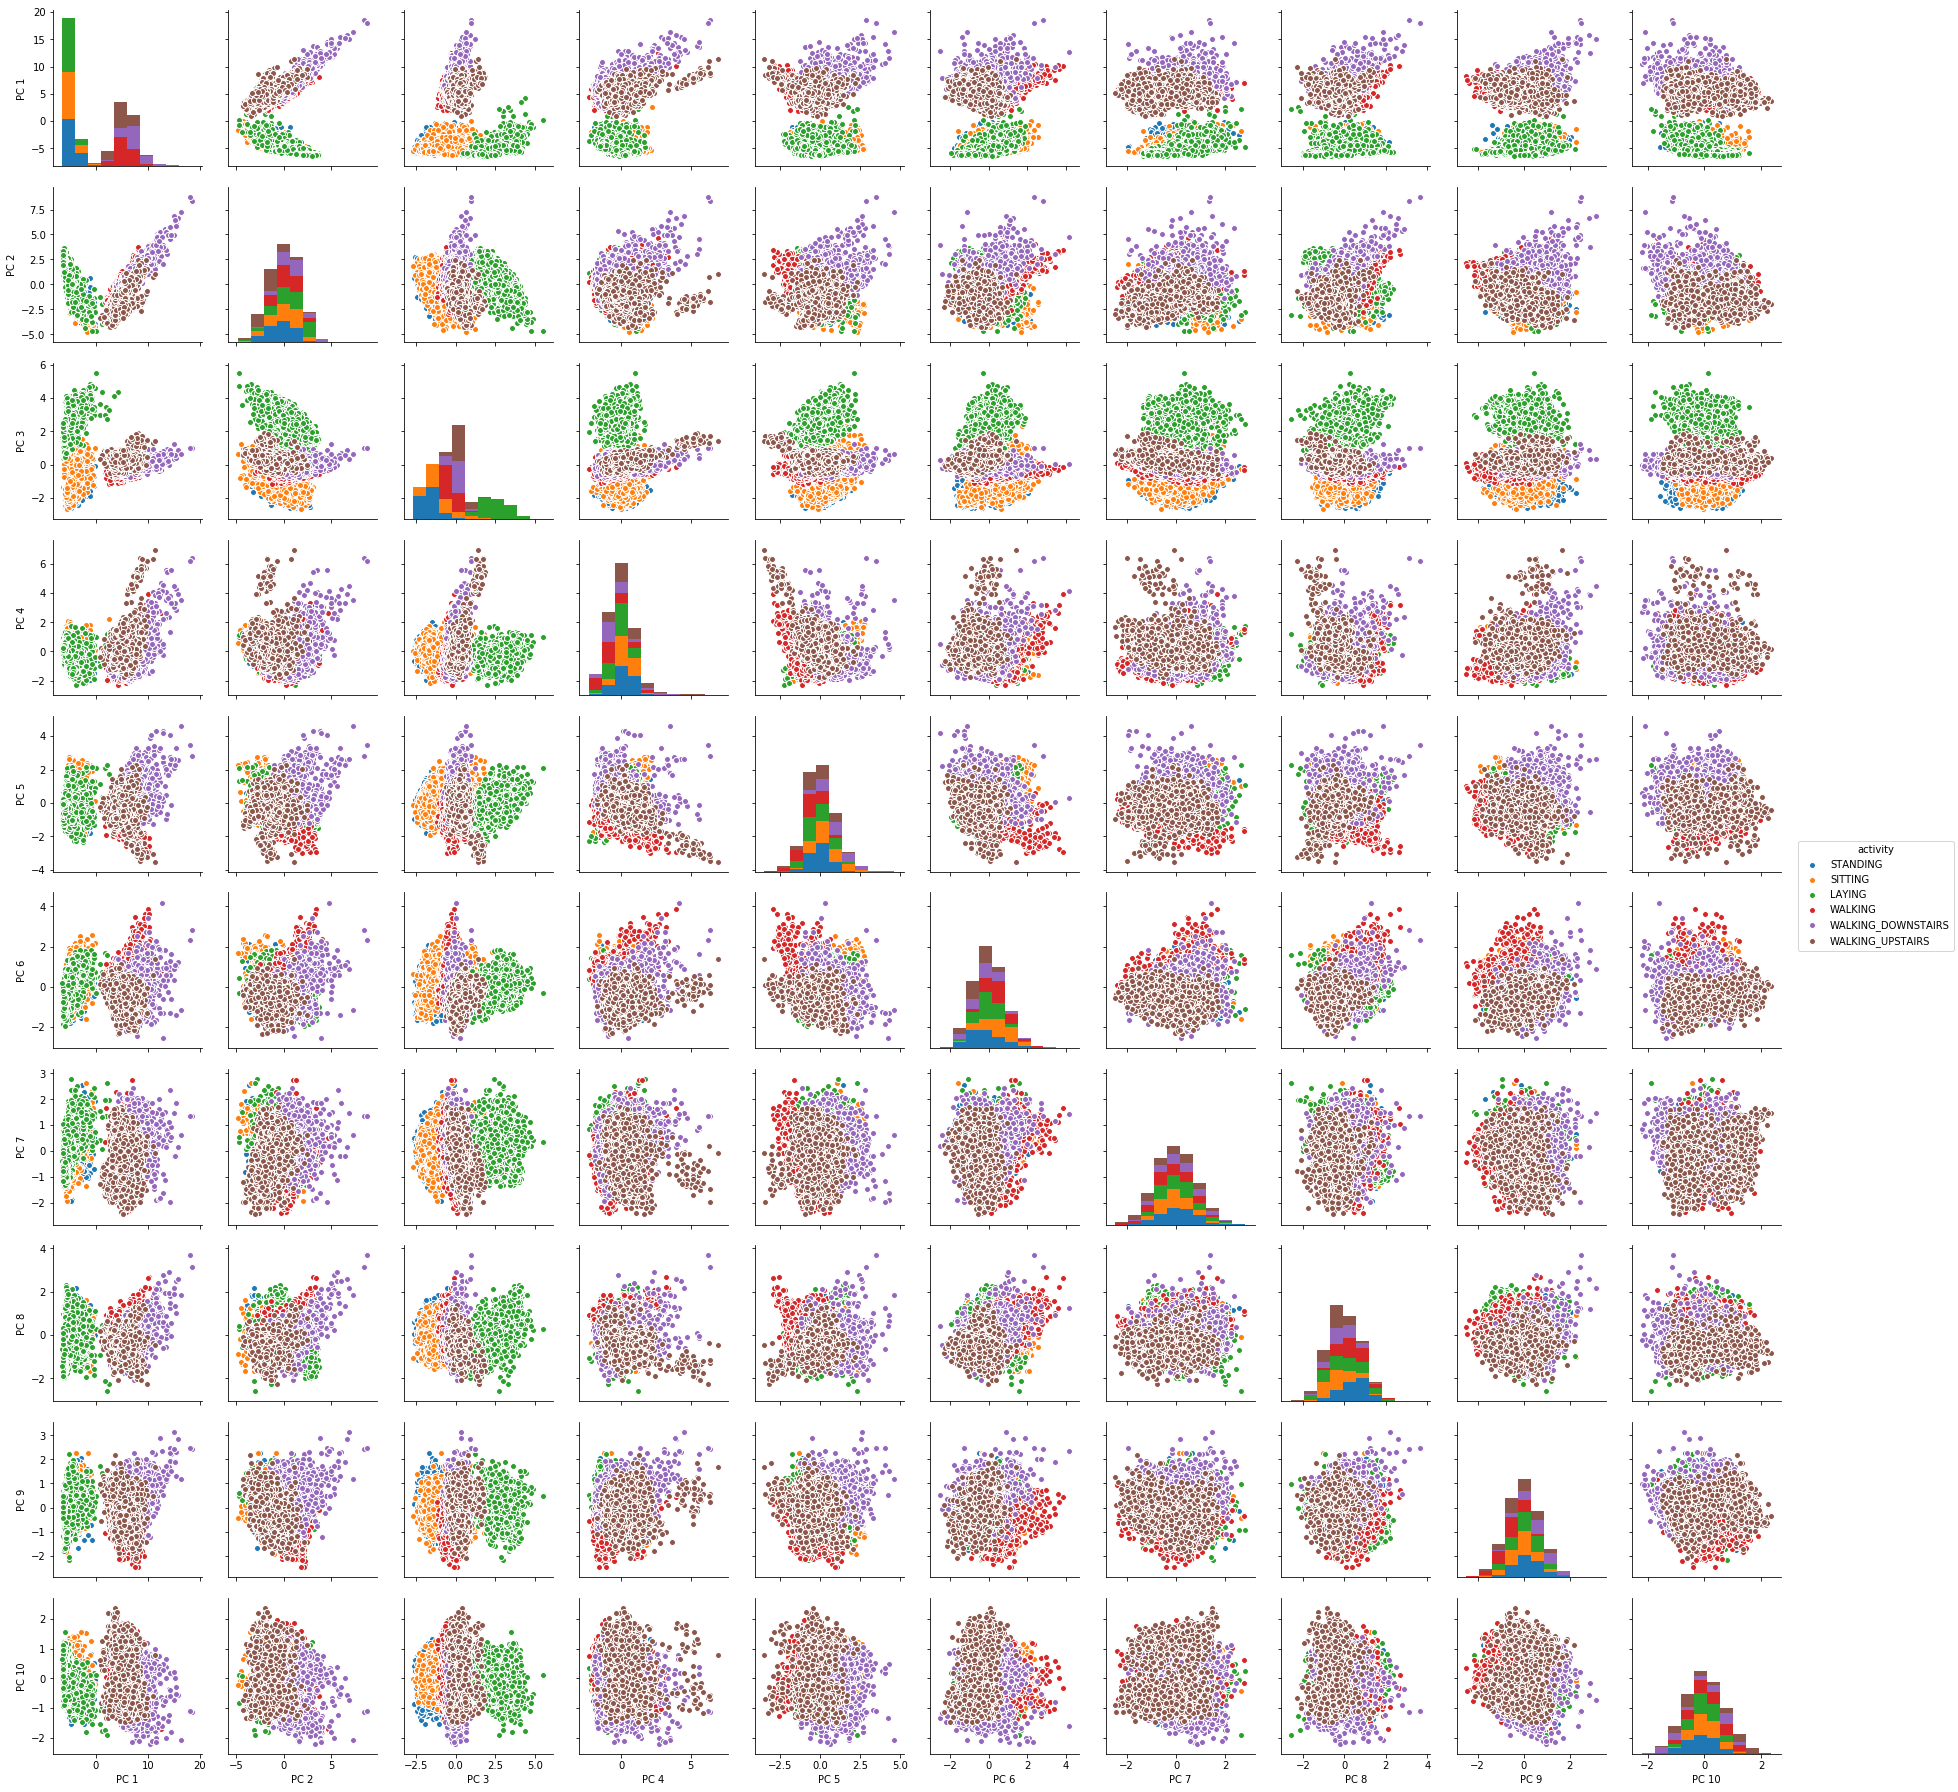

In [7]:
names =  list('PC {}'.format(i) for i in range(1,11))
PCA_10 = pd.DataFrame(X_train_pca[:,:10], columns=names)
PCA_10['activity'] = y_train.activity

sns.pairplot(PCA_10, hue='activity');

### From the plot it seems that:
* Laying will be the most easily classified action
* It may be difficult for classifiers to differentiate between standing and sitting
* It may be difficult for classifier to differentiate between the 3 walking actions

### Classifier performance will be tested using:
* 10 components - to confirm or reject hypothesis made based on the above visualization 
* 50 components
* 100 compoments

In [8]:
pca10 = PCA(n_components = 10)
pca50 = PCA(n_components = 50)
pca100 = PCA(n_components = 100)

pca10.fit(X_train)
pca50.fit(X_train)
pca100.fit(X_train)

X_train_10 = pca10.transform(X_train)
X_test_10 = pca10.transform(X_test)
X_train_50 = pca50.transform(X_train)
X_test_50 = pca50.transform(X_test)
X_train_100 = pca100.transform(X_train)
X_test_100 = pca100.transform(X_test)

### Classifiers:
* LDA - [inspiration](https://www.researchgate.net/publication/309373991_Modeling_Human_Activity_Recognition_by_Dimensionality_Reduction_Approach) for this method
* Logistic Regression
* MLPClassifier
* KNeighborsClassifier

In [9]:
#Import classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [10]:
lda = LinearDiscriminantAnalysis()
lr = LogisticRegression(random_state = 0)
mlp = MLPClassifier(random_state = 0)
knn = KNeighborsClassifier()

def train_predict(classifiers, X_train, X_test, y_train, y_test):
    from sklearn import metrics
    cm = {}
    acc = {}
    labels = list(np.unique(y_train))
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm[name] = metrics.confusion_matrix(y_test, y_pred, labels=labels)
        acc[name] = metrics.accuracy_score(y_test, y_pred)
    
    return cm, acc


classifiers = [lda, lr, mlp, knn]
name_order = [clf.__class__.__name__ for clf in classifiers]

cm_10, acc_10 = train_predict(classifiers, X_train_10, X_test_10, y_train.activity, y_test.activity)
cm_50, acc_50 = train_predict(classifiers, X_train_50, X_test_50, y_train.activity, y_test.activity)
cm_100, acc_100 = train_predict(classifiers, X_train_100, X_test_100, y_train.activity, y_test.activity)

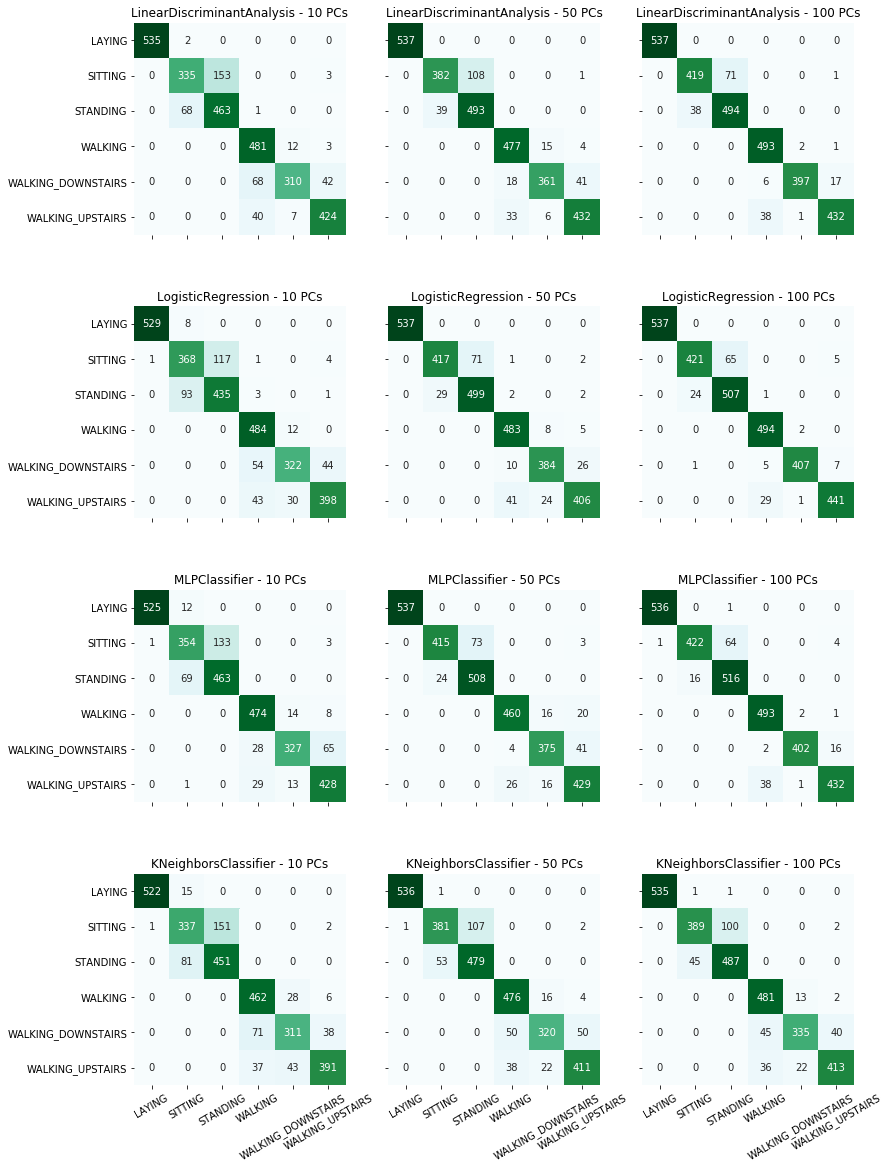

In [11]:
name_order = [name.__class__.__name__ for name in classifiers]
labels = list(np.unique(y_train.activity))

f, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(20,20))

for name, i in zip(name_order, range(4)):
    sns.heatmap(cm_10[name], cmap='BuGn', annot=True, fmt='g', cbar=False, square=True, xticklabels=labels, 
            yticklabels=labels,ax=axes[i,0]);
    axes[i,0].set_title('{} - 10 PCs'.format(name));
    
for name, i in zip(name_order, range(4)):
    sns.heatmap(cm_50[name], cmap='BuGn', annot=True, fmt='g', cbar=False, square=True, xticklabels=labels, 
            yticklabels=labels,ax=axes[i,1]);
    axes[i,1].set_title('{} - 50 PCs'.format(name));
    
for name, i in zip(name_order, range(4)):
    sns.heatmap(cm_100[name], cmap='BuGn', annot=True, fmt='g', cbar=False, square=True, xticklabels=labels, 
            yticklabels=labels,ax=axes[i,2]);
    axes[i,2].set_title('{} - 100 PCs'.format(name));    
    
plt.setp(axes[3,0].get_xticklabels(), rotation=30);
plt.setp(axes[3,1].get_xticklabels(), rotation=30);
plt.setp(axes[3,2].get_xticklabels(), rotation=30);
plt.subplots_adjust(left=0.4)

### Hypothesis from PCA visualization confirmed
From the above confusion matrices it is clear that the classifiers had the most difficulty distinguishing between the activites labeled sitting and standing as well as all of the activities involving walking.

Of particular interest is the observation that all of the classifiers aside from KNN misclassified walking upstairs as walking more frequently than they misclassified walking downstairs as walking when using 50 and 100 PCs.

In [12]:
for acc, pcs in zip([acc_10, acc_50, acc_100], [10,50,100]):
    print '\nAccuracy using {} PCs:'.format(pcs)
    for name in name_order:
        print '{}: {:.4f}'.format(name, acc[name])


Accuracy using 10 PCs:
LinearDiscriminantAnalysis: 0.8646
LogisticRegression: 0.8605
MLPClassifier: 0.8724
KNeighborsClassifier: 0.8395

Accuracy using 50 PCs:
LinearDiscriminantAnalysis: 0.9101
LogisticRegression: 0.9250
MLPClassifier: 0.9243
KNeighborsClassifier: 0.8833

Accuracy using 100 PCs:
LinearDiscriminantAnalysis: 0.9406
LogisticRegression: 0.9525
MLPClassifier: 0.9505
KNeighborsClassifier: 0.8958


#### These are decent results considering the dimensionality of the feature space was reduced by 98%, 91%, and 82% respectively.

### Optimization
While the results above are decent, can they be improved upon by tuning the hyperparameters of the classifiers?
* 50 PCs - Logistic Regression (highest performer) and KNN (lowest performer)
* 100 PCs - The top 3 performers will be optimized. KNN may be optimized depending on how tuneable it proves to be.

In [13]:
def optimize(classifiers, parameters, X_train, X_test, y_train, y_test, cv=5, show_params=False):
    from sklearn.model_selection import GridSearchCV
    from sklearn import metrics
    cm = {}
    acc = {}
    labels = list(np.unique(y_train))
    for clf, params in zip(classifiers, parameters):
        name = clf.__class__.__name__
        grid_obj = GridSearchCV(clf, params, cv=cv)
        grid_fit = grid_obj.fit(X_train, y_train)
        best_clf = grid_fit.best_estimator_
        y_pred = best_clf.predict(X_test)
        cm[name] = metrics.confusion_matrix(y_test, y_pred)
        acc[name] = metrics.accuracy_score(y_test, y_pred)
        if show_params:
            print 'Best parameters for {}:\n{}\n'.format(name, grid_fit.best_params_)
    return cm, acc



In [14]:
lr_params_50 = {'C':np.arange(7.1,7.3,0.01), 'solver':['lbfgs','liblinear']}
knn_params_50 = {'n_neighbors':range(15,50,5)}

clf_50 = [lr, knn]
params_50 = [lr_params_50, knn_params_50]


lr_params_100 = {'tol':[1e-1,1e-2,1e-3], 'C':np.arange(1,1.95,0.05), 'solver':['newton-cg', 'lbfgs','liblinear']}
lda_params = {'solver':['svd', 'lsqr','eigen']}
mlp_params = {'hidden_layer_sizes':range(150,260,10),'activation':['logistic', 'tanh', 'relu'], 'learning_rate_init':[0.02, 0.2, 1]}

clf_100 = [lr, lda, mlp]
params_100 = [lr_params_100, lda_params, mlp_params]

#MLP needed special attention
#clf_100 = [mlp]
#params_100 = [mlp_params]

In [15]:
cm_50, acc_50 = optimize(clf_50,params_50,X_train_50, X_test_50, y_train.activity, y_test.activity, show_params=True)

Best parameters for LogisticRegression:
{'C': 7.129999999999999, 'solver': 'lbfgs'}

Best parameters for KNeighborsClassifier:
{'n_neighbors': 20}



In [16]:
acc_50

{'KNeighborsClassifier': 0.8903970139124533,
 'LogisticRegression': 0.9277231082456736}

In [17]:
cm_100, acc_100 = optimize(clf_100, params_100, X_train_100, X_test_100, y_train.activity, y_test.activity, show_params=True)

Best parameters for LogisticRegression:
{'C': 1.7500000000000007, 'tol': 0.1, 'solver': 'newton-cg'}



C:\Users\alros\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\alros\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\alros\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Best parameters for LinearDiscriminantAnalysis:
{'solver': 'svd'}

Best parameters for MLPClassifier:
{'activation': 'relu', 'learning_rate_init': 0.02, 'hidden_layer_sizes': 230}



In [18]:
acc_100

{'LinearDiscriminantAnalysis': 0.9406175771971497,
 'LogisticRegression': 0.9507974211062097,
 'MLPClassifier': 0.9484221241940957}

#### As can be see above, optimizing these classifiers did not improve the accuracy scores significantly or at all. 
This data may be difficult to optimize due to how it was initially prepared (all features normalized between -1 and 1) and therefore it may simply be necessary to use more principal components if better results are desired. Perhaps a different method of dimensionality reduction or a different classifier may produce better results. Achieving 95% classification accuracy after reducing the data from 561 dimensions to 100 dimensions is still fairly decent. 